# Water Scarcity and Global Conflict Analysis
This project aims to explore the complex relationship between armed conflict and water scarcity by integrating and analyzing datasets from various sources. We will leverage geospatial and environmental data to assess how water scarcity influences the occurrence and intensity of conflicts.

## Project Summary

### Definitions
- Scarcity: Demand for a good or service is greater than the availability of the good or service (Oxford Languages).
- Supply: total freshwater resources available in cubic meters per person, per year (The ImpEE Project).
- Withdrawal: amount extracted for use by country (The ImpEE Project).
- Water Stress: ratio between total freshwater withdrawn (TFWW) and total renewable freshwater resources (TRWR). Water stress = TFWW / TRWR (Wikipedia).
- Water Scarcity: volume of fresh water available does not meet the per person per day recommendations for human health (University of Nottingham).er day
- Human Development Index (HDI): a statistical composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which is used to rank countries into four tiers of human development.
- Political Stability Index (PSI): Political Stability and Absence of Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution, i.e. ranging from approximately -2.5 to 2.5.

### Data Sources
- Food and Agriculture Organization (FAO) https://data.apps.fao.org/aquastat/?lang=en
- University of Alabama https://internationalconflict.ua.edu/data-download/
- Correlates of War (COW) https://correlatesofwar.org/data-sets/cow-country-codes-2/
- GitHub Countries with Regional Codes: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
- World Bank Group's Data Bank https://databank.worldbank.org/reports.aspx
- International Monetary Fund: https://www.imf.org/en/Home
- Bureau of Reclamation: https://www.usbr.gov/mp/arwec/water-facts-ww-water-sup.html

### Hypothesis: 
Water is one of the most critical resources on the planet for human survival. When the demand for critical resources, such as water, exceeds the supply, the number of conflicts increases.

### Questions:
- How does water scarcity correlate with the frequency and intensity of armed conflicts?
- What are the geographical patterns of conflict relative to water scarcity?
- Can changes in water availability predict increases in conflict events?
- Are certain types of conflicts more likely to occur in water-scarce regions?
- Are there other factors that affect the frequency of armed conflicts in water scarce areas?

## Task 1: Data Collection

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from functools import partial, reduce

In [2]:
# Collect water scarcity data from the Food and Agriculture Organization (FAO)
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System.csv')

# Collect international conflict data from the University of Alabama
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')

# Collect country codes from Correlates of War (COW)
COW_Country_Codes = pd.read_csv('Resources/COW-country-codes.csv')

# Collect country codes codes with regions from github
regions_csv = pd.read_csv('Resources/countries_regions.csv')

# Collect political stability data from World Bank Group
stability_csv = pd.read_csv('Resources/political_stability.csv')

# Collect precipitation by country from International Monetary Fund
precip_csv = pd.read_csv('Resources/wb_precipitation.csv')

# Collect freshwater resources per capita by country from International Monetary Fund
wtr_rsrc_csv = pd.read_csv('Resources/wb_wtr_rsrc.csv')

# Collect surface temperature by country from International Monetary Fund
srfc_temp_csv = pd.read_csv('Resources/imf_surface_temp.csv')

### Defined Functions

In [3]:
# Define a function to create Linear Regression plots
def linear_regression_plot(x, y):
    
    # Perform a linear regression on x and y variables
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x, y)
    
    # Get regression values
    regress_values = x * slope + intercept

    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    # Create Plot
    plt.scatter(x,y)
    plt.plot(x,regress_values,"r-")

    # Print r value
    print(f"The r-value is: {rvalue**2}")

    return (line_eq)

In [4]:
# Define a function to identify outliers
def dataset_analysis(dataset, df):

    # Get the from a column dataframe
    data = df[dataset]
        
    # Calculate analytical measures
    min = data.min()
    max = data.max()
    mean = data.mean()
    median = data.median()
    stddev = data.std()
    var = data.var()
    quartiles = data.quantile([0.25, 0.5, 0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)

    # Identify potential outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Print the results
    print(f"")
    print(f"------------------------------------------")
    print(f"Descriptive Analysis of {dataset} dataset ") 
    print(f"")
    print(f"Measures of Central Tendency")
    print(f"Min: {min}")
    print(f"Max: {max}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {stddev}")
    print(f"Variance: {var}")
    print(f"")
    print(f"Interquartile Range (IQR)")
    print(f"Lower Quartile: {lowerq}")
    print(f"Upper Quartile: {upperq}")
    print(f"IQR: {iqr}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"")
    
    # Store outliers only if there are any
    if not outliers.empty:
        print(f"Outliers: {outliers}")
        print(f"------------------------------------------")
        print(f"")
    
    # Check if any outliers were found
    if outliers.empty:
        print(f"Outliers: no outliers found")
        print(f"------------------------------------------")

## Task 2: Data Cleanup

In [5]:
# Create a dictionary for the country codes and their names and the confrontation codes and their name
code_to_country = pd.Series(COW_Country_Codes.StateNme.values, index=COW_Country_Codes.CCode).to_dict()
conflict_name = pd.Series(micnames.micname.values, index= micnames.micnum).to_dict()

regions_df = regions_csv[['name', 'region', 'sub-region']].copy().rename(columns={'name': 'Country'})
regions_df.head(1)

,Country,region,sub-region
0,Afghanistan,Asia,Southern Asia


### Cleanup the Militarized Interstate Events (MIE) csv

In [6]:
# Copy the dataframe with only the columns we want 
mie_df = mie_csv[['styear', 'ccode1', 'eventnum', 'micnum', 'hostlev', 'ccode2']].copy()

# Map the country codes to their names from the dictionary and replace
mie_df['ccode1'] = mie_df['ccode1'].map(code_to_country)
mie_df['ccode2'] = mie_df['ccode2'].map(code_to_country)
#mie_df['micnum'] = mie_df['micnum'].map(conflict_name)

# Rename columns headers
mie_df = mie_df.rename(columns={'styear': 'Year',
                                'ccode1': 'Country',
                                'ccode2': 'Target Country',
                                'eventnum': 'Event Number',
                                'micnum': 'Conflict',
                                'hostlev': 'Hosility Level'
                                })

# Add regions to dataframe
mie_df = pd.merge(mie_df, regions_df, on=['Country'])

# Filter for years between 1980 and 2015
mie_df = mie_df[(mie_df['Year'] >= 1980) & (mie_df['Year'] <= 2015)]

# Display the clean dataframe
mie_df.head(1)

,Year,Country,Event Number,Conflict,Hosility Level,Target Country,region,sub-region
12546,1980,Thailand,41,1232,4,Vietnam,Asia,South-eastern Asia


In [7]:
# Group by 'Year' and count unique 'micnum' for each year
mie_per_year_df = mie_df.groupby(['Year', 'region', 'sub-region', 'Country'])['Conflict'].nunique().reset_index()
# Display the clean dataframe
mie_per_year_df.head(1)

,Year,region,sub-region,Country,Conflict
0,1980,Africa,Northern Africa,Egypt,1


### Cleanup the AQUASTAT csv

In [8]:
# Copy the dataframe with only the columns we want 
aqua_df = aqua_csv[['Year', 'Area', 'Variable', 'Value', 'Unit']].copy()

# Rename column header
aqua_df = aqua_df.rename(columns={'Area': 'Country'})

# Replace country with dictionary values
aqua_df['Country'] = aqua_df['Country'].replace(code_to_country)

# Filter for years between 1980 and 2015
aqua_df = aqua_df[(aqua_df['Year'] >= 1980) & (aqua_df['Year'] <= 2014)]
aqua_df.head(1)

,Year,Country,Variable,Value,Unit
13,1980,Afghanistan,Population density,19.126047,inhab/km2


In [9]:
# Create dataframe for Human Capital Index (max value = 1)
hdi_df = aqua_df.loc[aqua_df['Variable'] == 'Human Development Index (HDI) [highest = 1]']
hdi_df = hdi_df.rename(columns={'Value': 'HDI'}).drop(columns=['Variable', 'Unit'])
hdi_df.head(1)

,Year,Country,HDI
78609,1990,Afghanistan,0.298


In [10]:
# Create dataframe for Pop Density (ppl/km2)
pop_dens_df = aqua_df.loc[aqua_df['Variable'] == 'Population density']
pop_dens_df = pop_dens_df.rename(columns={'Value': 'Pop Density'}).drop(columns=['Variable', 'Unit'])
pop_dens_df.head(1)

,Year,Country,Pop Density
13,1980,Afghanistan,19.126047


In [11]:
# Create dataframe for Wtr Stress %
wstress_df = aqua_df.loc[aqua_df['Variable'] == 'SDG 6.4.2. Water Stress']
wstress_df = wstress_df.rename(columns={'Value': 'Wtr Stress'}).drop(columns=['Variable', 'Unit'])
wstress_df.head(1)

,Year,Country,Wtr Stress
24129,1980,Afghanistan,46.22379


In [12]:
# Create dataframe for Total exploitable water resources (1b m3/yr)
tw_res_df = aqua_df.loc[aqua_df['Variable'] == 'Total exploitable water resources']
tw_res_df = tw_res_df.rename(columns={'Value': 'Tot Wtr Resource'}).drop(columns=['Variable', 'Unit'])
tw_res_df.head(1)

,Year,Country,Tot Wtr Resource
20915,1980,Albania,13.0


In [13]:
# Create dataframe for Total freshwater withdrawal 1b m3/yr)
tfw_wdrl_df = aqua_df.loc[aqua_df['Variable'] == 'Total freshwater withdrawal']
tfw_wdrl_df = tfw_wdrl_df.rename(columns={'Value': 'FreshW Wdrl'}).drop(columns=['Variable', 'Unit'])
tfw_wdrl_df.head(1)

,Year,Country,FreshW Wdrl
72298,1980,Afghanistan,17.121292


In [14]:
# Create dataframe for Total Population (1000ppl)
tpop_df = aqua_df.loc[aqua_df['Variable'] == 'Total population']
tpop_df = tpop_df.rename(columns={'Value': 'Total Population'}).drop(columns=['Variable', 'Unit'])
tpop_df.head(1)

,Year,Country,Total Population
10200,1980,Afghanistan,12486.631


In [15]:
# Create dataframe for Total Water Withdrawl (ppl/km2)
twdrl_df = aqua_df.loc[aqua_df['Variable'] == 'Total water withdrawal']
twdrl_df = twdrl_df.rename(columns={'Value': 'Total Withdrawl'}).drop(columns=['Variable', 'Unit'])
twdrl_df.head(1)

,Year,Country,Total Withdrawl
59217,1980,Afghanistan,17.121292


In [16]:
# Create dataframe for Total water withdrawal per capita (m3/ppl/yr)
tw_wdrl_pc_df = aqua_df.loc[aqua_df['Variable'] == 'Total water withdrawal per capita']
tw_wdrl_pc_df = tw_wdrl_pc_df.rename(columns={'Value': 'Wtr Withdrawl'}).drop(columns=['Variable', 'Unit'])
tw_wdrl_pc_df.head(1)

,Year,Country,Wtr Withdrawl
65751,1980,Afghanistan,1371.169827


In [17]:
# Make a list of dataframes
aqua_df_lst = [hdi_df, pop_dens_df, wstress_df, tw_res_df, tfw_wdrl_df, tpop_df, twdrl_df, tw_wdrl_pc_df]

# Create a clean dataframe for water data 
aqua_df_clean = reduce(lambda left,right: pd.merge(left,right,on=['Year', 'Country'],how='inner'), aqua_df_lst)
aqua_df_clean.head(1)

,Year,Country,HDI,Pop Density,Wtr Stress,Tot Wtr Resource,FreshW Wdrl,Total Population,Total Withdrawl,Wtr Withdrawl
0,1990,Albania,0.644,114.610991,7.211538,13.0,1.2,3295.066,1.2,364.180869


### Cleanup World Bank Group csv files

#### Cleanup World Bank Group Political Stability csv

In [18]:
# Create stability dataframe from csv: set country as index, drop unused columns, stack the remaining columns, and reset the index
stability_df = stability_csv.set_index('Country Name').drop(columns=['Series Name', 'Series Code', 'Country Code']).stack().reset_index()

# Rename the column headers and replace null values ".." with 0
stability_df = stability_df.rename(columns={'Country Name': 'Country',
                                                  'level_1': 'Year',
                                                  0: 'Pol Stability'
                                                 }).replace('..', 0)

# Grab the first four values of the year column and convert to an integer
stability_df['Year'] = stability_df['Year'].str[0:4].astype(int)

# Filter by selected date range 1980 - 2015
stability_df = stability_df[stability_df['Year'].between(1980,2015)]

# Replace country with dictionary values
stability_df['Country'] = stability_df['Country'].replace(code_to_country)

# Display the clean dataframe
stability_df.head(1)

,Country,Year,Pol Stability
0,Afghanistan,1996,-2.417309523


#### Cleanup World Bank Group Precipitation csv

In [19]:
# Create precipitation dataframe from csv: set country as index, drop unused columns, stack the remaining columns, and reset the index
precip_df = precip_csv.set_index('Country Name').drop(columns=['Country Code', 'Indicator Name', 'Indicator Code']).stack().reset_index()

# Rename the column headers and replace null values ".." with 0
precip_df = precip_df.rename(columns={'Country Name': 'Country',
                                                    'level_1': 'Year',
                                                    0: 'Precipitation'
                                                    })

# Convert to an integer
precip_df['Year'] = precip_df['Year'].astype(int)

# Filter by selected date range 1980 - 2015
precip_df = precip_df[precip_df['Year'].between(1980,2015)]

# Replace country with dictionary values
precip_df['Country'] = precip_df['Country'].replace(code_to_country)

# Display the clean dataframe
precip_df.head(1)

,Country,Year,Precipitation
19,Afghanistan,1980,327.0


#### Cleanup World Bank Group Freshwater Resources Per Capita csv

In [20]:
# Create a freshwater resources dataframe from csv: set country as index, drop unused columns, stack the remaining columns, and reset the index
wtr_rsrc_df = wtr_rsrc_csv.set_index('Country Name').drop(columns=['Country Code', 'Indicator Name', 'Indicator Code']).stack().reset_index()

# Rename the column headers and replace null values ".." with 0
wtr_rsrc_df = wtr_rsrc_df.rename(columns={'Country Name': 'Country',
                                                    'level_1': 'Year',
                                                    0: 'FrshW / Cap'
                                                    })

# Convert to an integer
wtr_rsrc_df['Year'] = wtr_rsrc_df['Year'].astype(int)

# Filter by selected date range 1980 - 2015
wtr_rsrc_df = wtr_rsrc_df[wtr_rsrc_df['Year'].between(1980,2015)]

# Replace country with dictionary values
wtr_rsrc_df['Country'] = wtr_rsrc_df['Country'].replace(code_to_country)
wtr_rsrc_df['FrshW / Cap'] = wtr_rsrc_df['FrshW / Cap'].astype(int)

# Display the clean dataframe
wtr_rsrc_df.head(1)

,Country,Year,FrshW / Cap
19,Africa Eastern and Southern,1980,10554


### Cleanup International Monetary Fund Surface Temperature csv

In [21]:
# Create a surface temp dataframe from csv: set country as index, drop unused columns, stack the remaining columns, and reset the index
srfc_temp_df = srfc_temp_csv.set_index('Country').drop(columns=['ObjectId',
                                                                'ISO2',
                                                                'ISO3',
                                                                'Indicator',
                                                                'Unit',
                                                                'Source',
                                                                'CTS Code',
                                                                'CTS Name',
                                                                'CTS Full Descriptor',
                                                                ]).stack().reset_index()

# Rename the column headers and replace null values ".." with 0
srfc_temp_df = srfc_temp_df.rename(columns={'level_1': 'Year',
                                                    0: 'Surf Temp'
                                                    })

# Convert to an integer
srfc_temp_df['Year'] = srfc_temp_df['Year'].astype(int)

# Filter by selected date range 1980 - 2015
srfc_temp_df = srfc_temp_df[srfc_temp_df['Year'].between(1980,2015)]

# Replace country with dictionary values
srfc_temp_df['Country'] = srfc_temp_df['Country'].replace(code_to_country)

# Convert to Fahrenheit
srfc_temp_df['Surf Temp'] = ((srfc_temp_df['Surf Temp'] * 9/5) + 32).astype(int)

# Display the clean dataframe
srfc_temp_df.head(1)

,Country,Year,Surf Temp
19,"Afghanistan, Islamic Rep. of",1980,33


## Task 3: Topic 4 Data Integration

In [22]:
# Make a list of dataframes
geo_df_lst = [mie_per_year_df, precip_df, wtr_rsrc_df, srfc_temp_df]

# Create a dataframe from columns needed for analysis
geo_df = reduce(lambda left,right: pd.merge(left,right,on=['Year', 'Country'],how='left'), geo_df_lst).fillna(0)

geo_df['Year'] = geo_df['Year'].astype(int)

# Display the final merged clean dataframe for analysis
geo_df.tail(1)

,Year,region,sub-region,Country,Conflict,Precipitation,FrshW / Cap,Surf Temp
1019,2014,Europe,Western Europe,Germany,1,700.0,1321.0,36.0


#### Region Dataframe for Topic 4 Analysis

In [23]:
# Calculate the average precipitation by region
avg_precip_reg = geo_df.groupby(['region'])['Precipitation'].mean()

# Calculate the average freshwater/capita by region
avg_frshw_reg = geo_df.groupby(['region'])['FrshW / Cap'].mean()

# Calculate the average surface temperature by region
avg_temp_reg = geo_df.groupby(['region'])['Surf Temp'].mean()

# Count number of conflicts per region
conf_reg = geo_df[geo_df['Conflict'] != 0].groupby('region').size()

# Create a new dataframe by region for these three measures
region_geo_df = pd.DataFrame({'Precipitation': avg_precip_reg,
                              'FrshW / Cap': avg_frshw_reg,
                              'Surf Temp': avg_temp_reg,
                              'No. Conflicts': conf_reg}).reset_index()
region_geo_df.head()

,region,Precipitation,FrshW / Cap,Surf Temp,No. Conflicts
0,Africa,727.792000,5951.612000,22.008000,250
1,Americas,1483.310559,37456.254658,24.894410,161
2,Asia,858.312925,3844.242630,22.786848,441
3,Europe,832.503106,19722.639752,28.397516,161
4,Oceania,2008.000000,112180.857143,32.285714,7


#### Sub-Region Dataframe for Topic 4 Analysis

In [24]:
# Calculate the average precipitation by subregion
avg_precip_subreg = geo_df.groupby(['sub-region'])['Precipitation'].mean()

# Calculate the average freshwater/capita by subregion
avg_frshw_subreg = geo_df.groupby(['sub-region'])['FrshW / Cap'].mean()

# Calculate the average surface temperature by subregion
avg_temp_subreg = geo_df.groupby(['sub-region'])['Surf Temp'].mean()

# Count number of conflicts per subregion
conf_subreg = geo_df[geo_df['Conflict'] != 'No Conflict'].groupby('sub-region').size()

# Create a new dataframe by subregion for these three measures
subregion_geo_df = pd.DataFrame({'Precipitation': avg_precip_subreg,
                                 'FrshW / Cap': avg_frshw_subreg,
                                 'Surf Temp': avg_temp_subreg,
                                 'No. Conflicts': conf_subreg}).reset_index().fillna(0)

# Check if all values in a row are 0
mask = (subregion_geo_df == 0).all(axis=1)

# Filter out rows with all 0 values
subregion_geo_df = subregion_geo_df[~(subregion_geo_df[['Precipitation', 'FrshW / Cap', 'FrshW / Cap']] == 0).all(axis=1)]

# Change values to integers
subregion_geo_df['No. Conflicts'] = subregion_geo_df['No. Conflicts'].astype(int)

subregion_geo_df.head(1)

,sub-region,Precipitation,FrshW / Cap,Surf Temp,No. Conflicts
0,Australia and New Zealand,534.0,26034.666667,32.333333,3


#### Country Dataframe for Topic 4 Analysis

In [25]:
# Calculate the average precipitation by country
avg_precip_country = geo_df.groupby(['Country'])['Precipitation'].mean()

# Calculate the average freshwater/capita by country
avg_frshw_country = geo_df.groupby(['Country'])['FrshW / Cap'].mean()

# Calculate the average surface temperature by country
avg_temp_country = geo_df.groupby(['Country'])['Surf Temp'].mean()

# Count number of conflicts per country
conf_country = geo_df[geo_df['Conflict'] != 'No Conflict'].groupby('Country').size()

# Create a new dataframe by country for these three measures
country_geo_df = pd.DataFrame({'Precipitation': avg_precip_country,
                               'FrshW / Cap': avg_frshw_country,
                               'Surf Temp': avg_temp_country,
                               'No. Conflicts': conf_country}).reset_index().fillna(0)

# Filter out rows with all 0 values
country_geo_df = country_geo_df[~(country_geo_df[['Precipitation', 'FrshW / Cap', 'FrshW / Cap']] == 0).all(axis=1)]

# Change values to integers
country_geo_df['No. Conflicts'] = country_geo_df['No. Conflicts'].astype(int)

country_geo_df.head(1)

,Country,Precipitation,FrshW / Cap,Surf Temp,No. Conflicts
0,Afghanistan,327.0,2813.583333,0.0,24


#### Year Dataframe for Topic 4 Analysis

In [26]:
# Calculate the average precipitation by year
avg_precip_yr = geo_df.groupby(['Year'])['Precipitation'].mean()

# Calculate the average freshwater/capita by year
avg_frshw_yr = geo_df.groupby(['Year'])['FrshW / Cap'].mean()

# Calculate the average surface temperature by year
avg_temp_yr = geo_df.groupby(['Year'])['Surf Temp'].mean()

# Count number of conflicts per country
conf_yr = geo_df[geo_df['Conflict'] != 'No Conflict'].groupby('Year').size()

# Create a new dataframe by country for these three measures
yr_geo_df = pd.DataFrame({'Precipitation': avg_precip_yr,
                          'FrshW / Cap': avg_frshw_yr,
                          'Surf Temp': avg_temp_yr,
                          'No. Conflicts': conf_yr}).reset_index().fillna(0)

# Change values to integers
yr_geo_df['Year'] = yr_geo_df['Year'].astype(int)
yr_geo_df['No. Conflicts'] = yr_geo_df['No. Conflicts'].astype(int).dropna()

yr_geo_df.tail(1)

,Year,Precipitation,FrshW / Cap,Surf Temp,No. Conflicts
34,2014,915.586207,9223.62069,26.793103,29


## Task 4: Topic 4 - Geographical Factors Affecting Frequency of Armed Conflict

### Datasets Analysis
The goal of this task is to analyze other possible geographical factors that could contribute to a rise in conflicts. The three factors selected were precipitation, freshwater per capita, and surface temperature.
- Global Pie Charts: only 3% of the world's water is freshwater, and only 0.5% of the world's water is available for human use. This reveals that water is inherently scarce on the planet.
- Regional Bar Charts: there appears to be a relationship between conflicts by region and the three factors, but this is very high-level.
- Sub-Regional Bar Charts: there appears to be a relationship between conflicts by region and the average precipitation and freshwater. When precipitation and freshwater are high, the number of conflicts appears to be lower, and vice versa. The average temperature over this timespan does not appear to correlate to the number of conflicts.
- Timescale bar/line charts: When looking at trends over time between conflicts and the three factors, there appears to be a slight correlation between any of the three factors.
- Performing linear regression, the r-values are: Precipitation - 0.03, Freshwater - 0.16, and Temperature - 0.004. This reveals that of the three additional factors for consideration that both precipitation and temperature have very weak positive correlations, and the average freshwater per capita has a weak positive correlation.

#### Descriptive Analytics

In [27]:
analysis_ncc = dataset_analysis('No. Conflicts',yr_geo_df)


------------------------------------------
Descriptive Analysis of No. Conflicts dataset 

Measures of Central Tendency
Min: 14
Max: 51
Mean: 29.142857142857142
Median: 29.0
Standard Deviation: 8.735131424792838
Variance: 76.30252100840336

Interquartile Range (IQR)
Lower Quartile: 23.5
Upper Quartile: 34.5
IQR: 11.0
Lower Bound: 7.0
Upper Bound: 51.0

Outliers: no outliers found
------------------------------------------


In [28]:
analysis_ncc = dataset_analysis('Precipitation',yr_geo_df)


------------------------------------------
Descriptive Analysis of Precipitation dataset 

Measures of Central Tendency
Min: 701.6470588235294
Max: 1334.8666666666666
Mean: 936.2298433408621
Median: 927.8484848484849
Standard Deviation: 139.9543021103203
Variance: 19587.206679186802

Interquartile Range (IQR)
Lower Quartile: 841.9931941923775
Upper Quartile: 1015.2282608695652
IQR: 173.23506667718777
Lower Bound: 582.1405941765959
Upper Bound: 1275.080860885347

Outliers: 8    1334.866667
Name: Precipitation, dtype: float64
------------------------------------------



In [29]:
analysis_ncc = dataset_analysis('FrshW / Cap',yr_geo_df)


------------------------------------------
Descriptive Analysis of FrshW / Cap dataset 

Measures of Central Tendency
Min: 4161.888888888889
Max: 31255.295454545456
Mean: 12121.195961654676
Median: 9831.97619047619
Standard Deviation: 6901.040368603848
Variance: 47624358.169099934

Interquartile Range (IQR)
Lower Quartile: 6911.918181818182
Upper Quartile: 15699.45925925926
IQR: 8787.541077441078
Lower Bound: -6269.393434343434
Upper Bound: 28880.770875420876

Outliers: 19    31255.295455
Name: FrshW / Cap, dtype: float64
------------------------------------------



In [30]:
analysis_ncc = dataset_analysis('Surf Temp',yr_geo_df)


------------------------------------------
Descriptive Analysis of Surf Temp dataset 

Measures of Central Tendency
Min: 16.541666666666668
Max: 28.8
Mean: 23.928930626839442
Median: 23.944444444444443
Standard Deviation: 2.6890573912860654
Variance: 7.23102965363022

Interquartile Range (IQR)
Lower Quartile: 22.55942028985507
Upper Quartile: 25.70740740740741
IQR: 3.14798711755234
Lower Bound: 17.83743961352656
Upper Bound: 30.42938808373592

Outliers: 26    16.541667
Name: Surf Temp, dtype: float64
------------------------------------------



#### Global Pie Charts

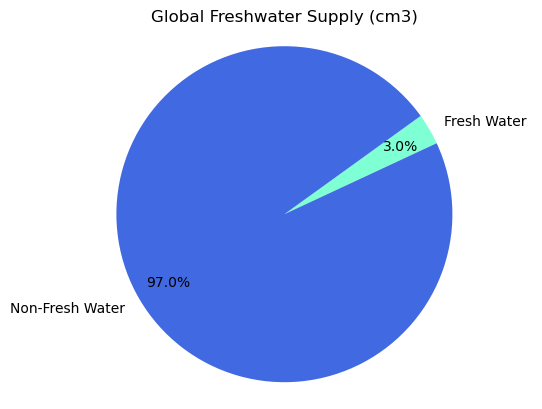

In [31]:
# Source Bureau of Reclamation: https://www.usbr.gov/mp/arwec/water-facts-ww-water-sup.html
# Create a dataframe using water totals in cubic miles from the US B
global_labels = ['Fresh Water', 'Non-Fresh Water']
global_data = [9780000, 316220000]

# Global Worldwide Water Supply Pie Chart
plt.pie(global_data, labels=global_labels, colors=['aquamarine', 'royalblue'], pctdistance=.80, autopct="%1.1f%%", startangle=25)
plt.title("Global Freshwater Supply (cm3)")

# Create axes which are equal so we have a perfect circle
plt.axis("equal")

plt.savefig("Images/World_Water_Pie.png")
plt.show()

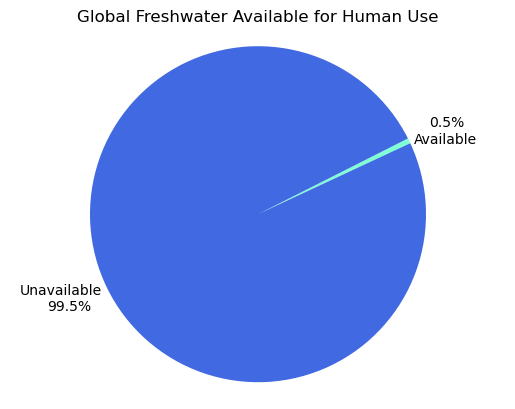

In [32]:
# Create a dataframe using water totals in cubic miles from the US B
global_labels = ['Available', 'Unavailable']
global_data = [1630000, 324370000]

# Global Worldwide Water Supply Pie Chart
plt.pie(global_data, labels=global_labels, colors=['aquamarine', 'royalblue'], pctdistance=1.25, labeldistance=1.03, 
        autopct='%1.1f%%', startangle=25)
plt.title("Global Freshwater Available for Human Use")

# Create axes which are equal so we have a perfect circle
plt.axis("equal")

plt.savefig("Images/World_Water_Pie2.png")
plt.show()

#### Regional Bar Charts

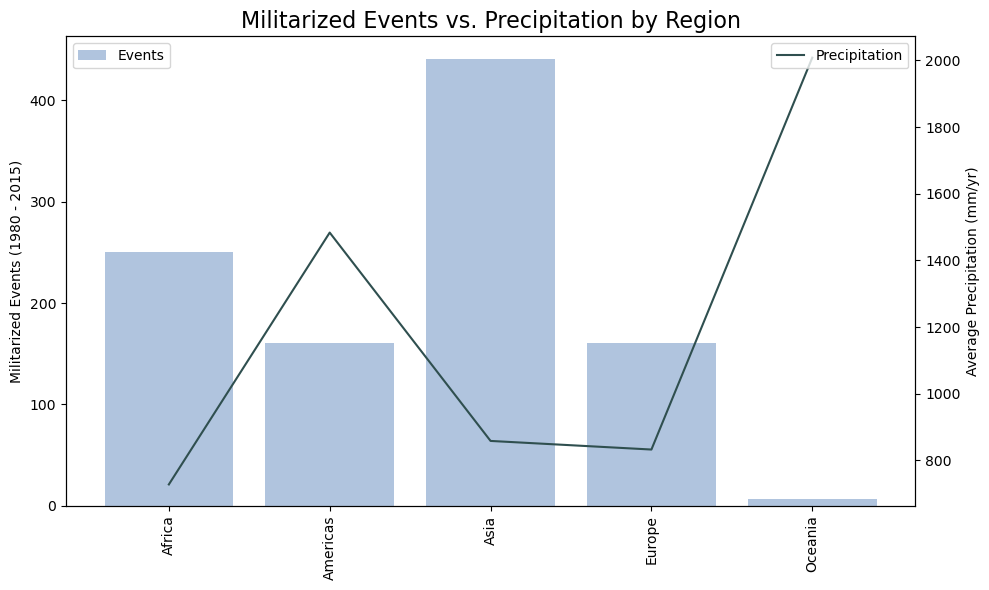

In [33]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Precipitation by Region', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Militarized Events (1980 - 2015)')
ax1.bar(region_geo_df['region'], region_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Precipitation (mm/yr)')
ax2.plot(region_geo_df['region'], region_geo_df['Precipitation'], color='darkslategray', label='Precipitation')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.show()

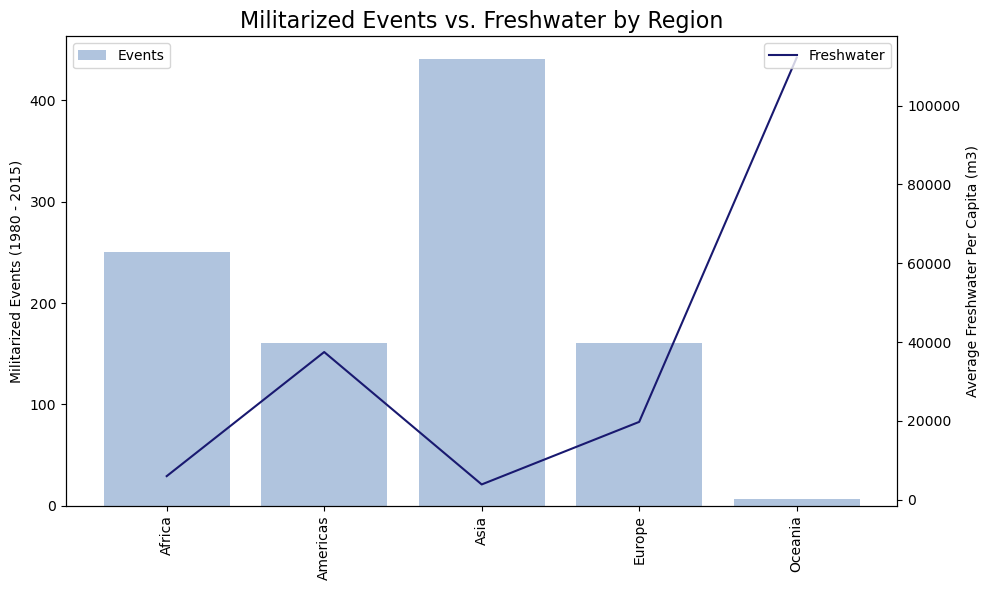

In [34]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Freshwater by Region', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Militarized Events (1980 - 2015)')
ax1.bar(region_geo_df['region'], region_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Freshwater Per Capita (m3)')
ax2.plot(region_geo_df['region'], region_geo_df['FrshW / Cap'], color='midnightblue', label='Freshwater')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.show()

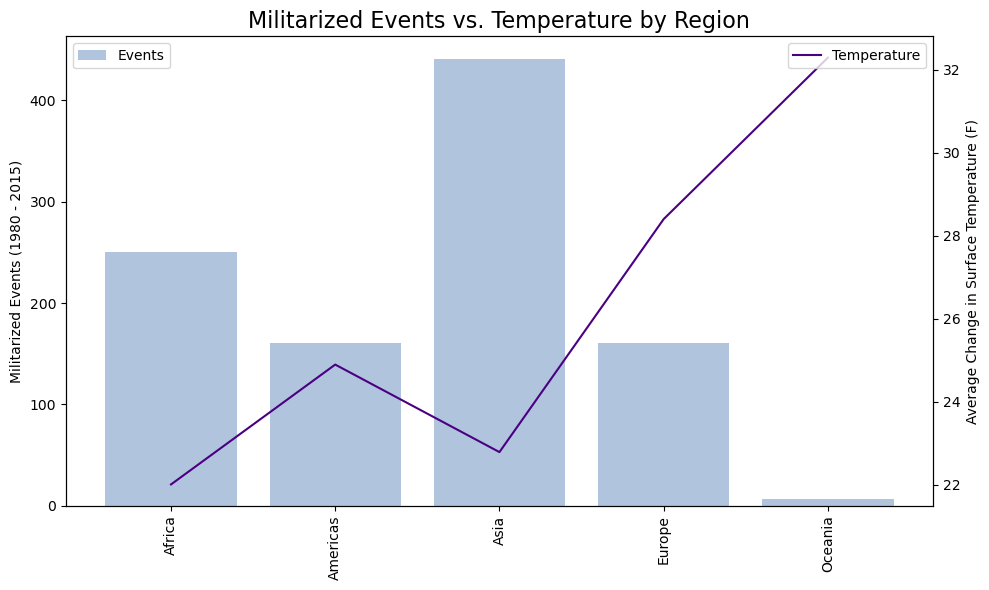

In [35]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Temperature by Region', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Militarized Events (1980 - 2015)')
ax1.bar(region_geo_df['region'], region_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Change in Surface Temperature (F)')
ax2.plot(region_geo_df['region'], region_geo_df['Surf Temp'], color='indigo', label='Temperature')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.show()

#### Sub-Region Bar Charts

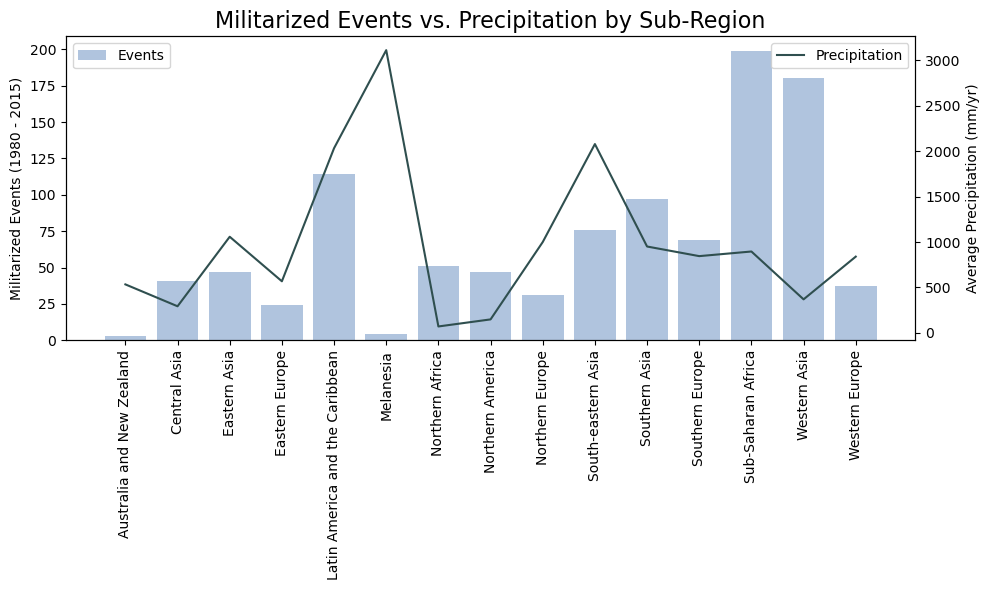

In [36]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Precipitation by Sub-Region', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Militarized Events (1980 - 2015)')
ax1.bar(subregion_geo_df['sub-region'], subregion_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Precipitation (mm/yr)')
ax2.plot(subregion_geo_df['sub-region'], subregion_geo_df['Precipitation'], color='darkslategray', label='Precipitation')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.savefig("Images/MIE_Prec_Bar.png")
plt.show()

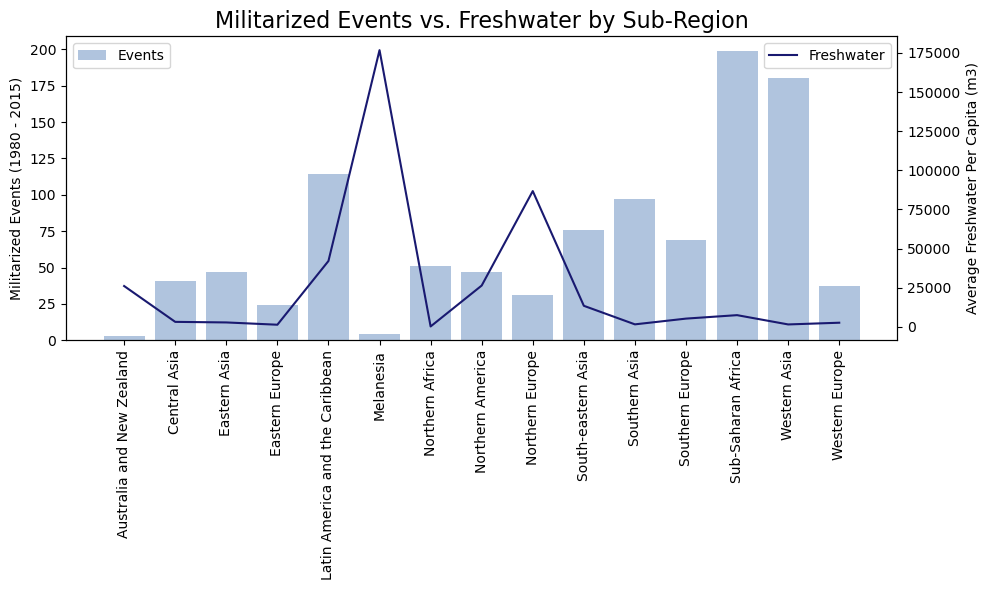

In [37]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Freshwater by Sub-Region', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Militarized Events (1980 - 2015)')
ax1.bar(subregion_geo_df['sub-region'], subregion_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Freshwater Per Capita (m3)')
ax2.plot(subregion_geo_df['sub-region'], subregion_geo_df['FrshW / Cap'], color='midnightblue', label='Freshwater')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.savefig("Images/MIE_FW_Bar.png")
plt.show()

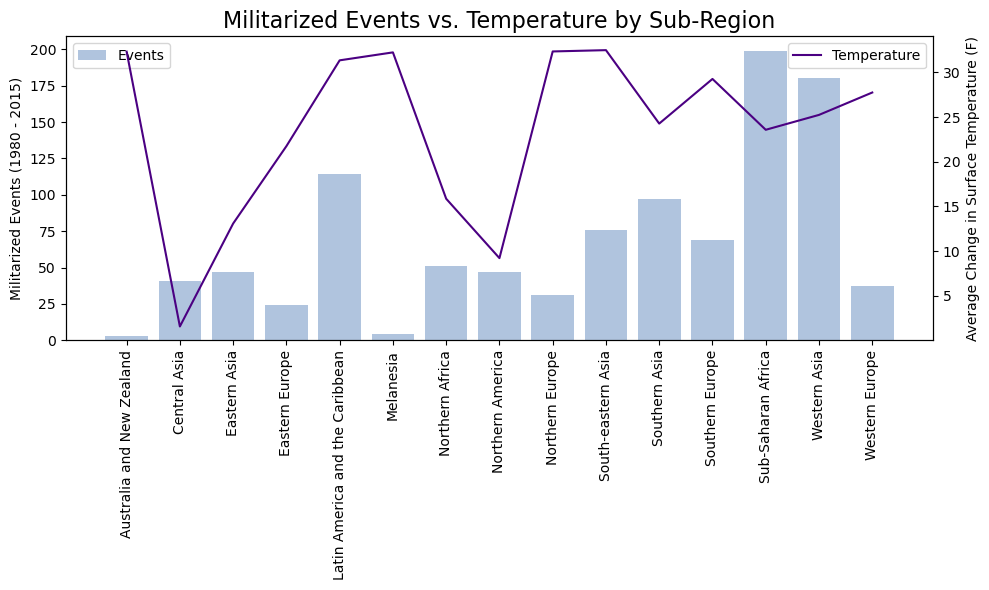

In [38]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Temperature by Sub-Region', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Militarized Events (1980 - 2015)')
ax1.bar(subregion_geo_df['sub-region'], subregion_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')
plt.xticks(rotation=90)

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Change in Surface Temperature (F)')
ax2.plot(subregion_geo_df['sub-region'], subregion_geo_df['Surf Temp'], color='indigo', label='Temperature')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.savefig("Images/MIE_Temp_Bar.png")
plt.show()

#### Timescale Bar Charts

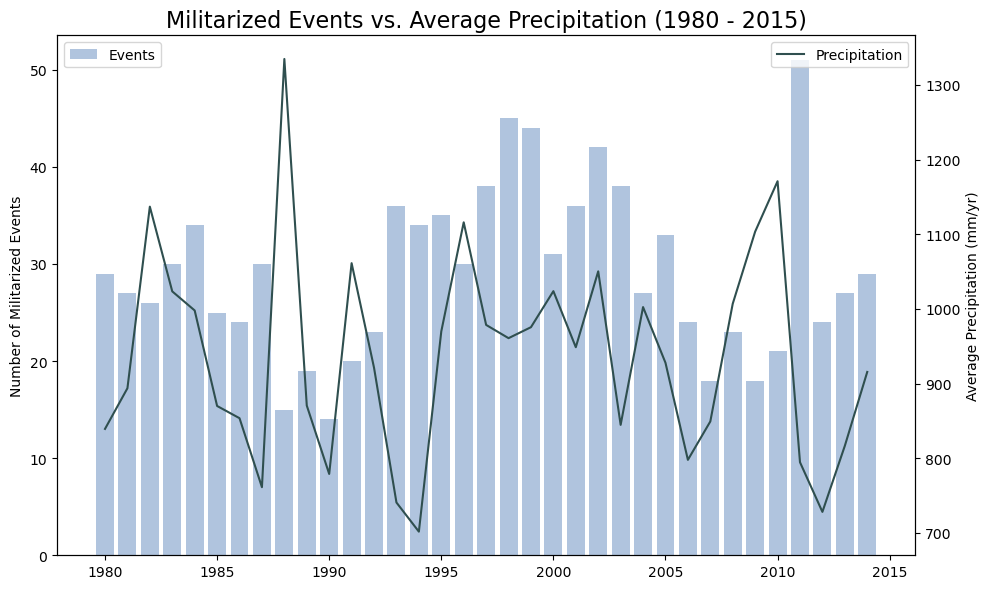

In [39]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Average Precipitation (1980 - 2015)', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Number of Militarized Events')
ax1.bar(yr_geo_df['Year'], yr_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Precipitation (mm/yr)')
ax2.plot(yr_geo_df['Year'], yr_geo_df['Precipitation'], color='darkslategray', label='Precipitation')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.savefig("Images/MIE_Prec_Bar2.png")
plt.show()

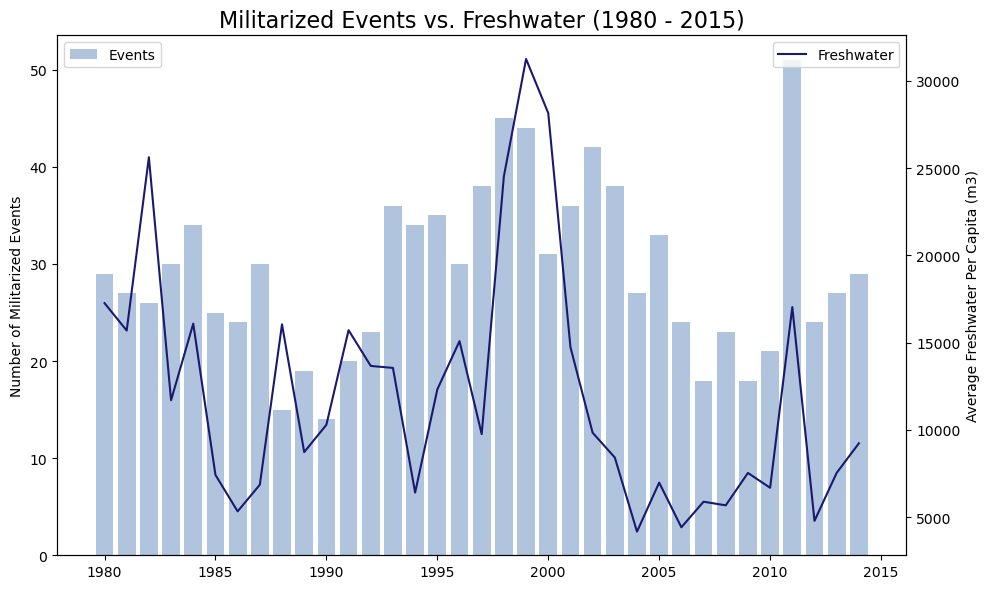

In [40]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Freshwater (1980 - 2015)', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Number of Militarized Events')
ax1.bar(yr_geo_df['Year'], yr_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Freshwater Per Capita (m3)')
ax2.plot(yr_geo_df['Year'], yr_geo_df['FrshW / Cap'], color='midnightblue', label='Freshwater')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.savefig("Images/MIE_FW_Bar2.png")
plt.show()

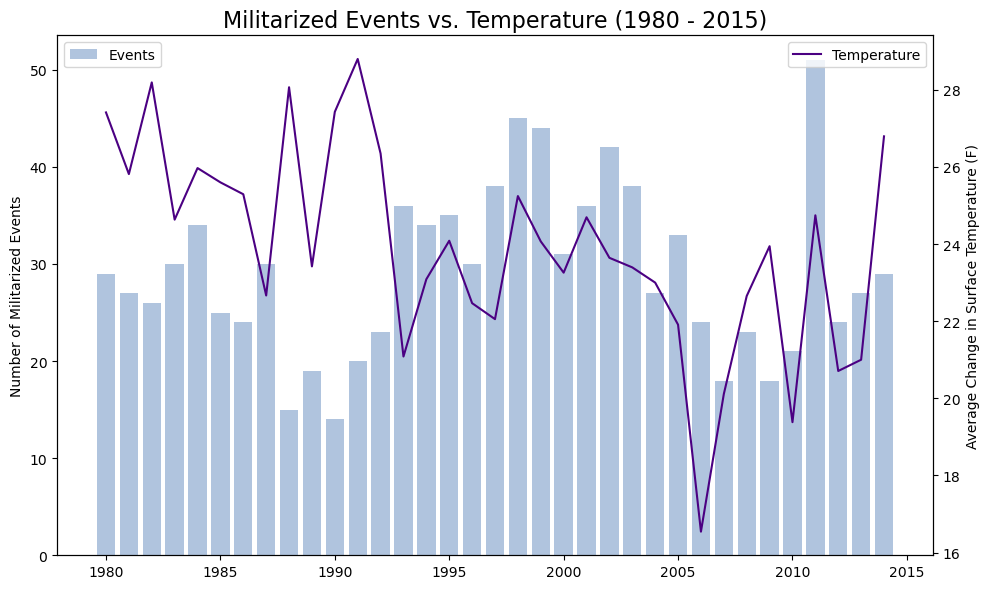

In [41]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Temperature (1980 - 2015)', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Number of Militarized Events')
ax1.bar(yr_geo_df['Year'], yr_geo_df['No. Conflicts'], color='lightsteelblue', label='Events')
ax1.legend(loc='upper left')

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Change in Surface Temperature (F)')
ax2.plot(yr_geo_df['Year'], yr_geo_df['Surf Temp'], color='indigo', label='Temperature')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.savefig("Images/MIE_Temp_Bar2.png")
plt.show()

#### Timescale Line Charts

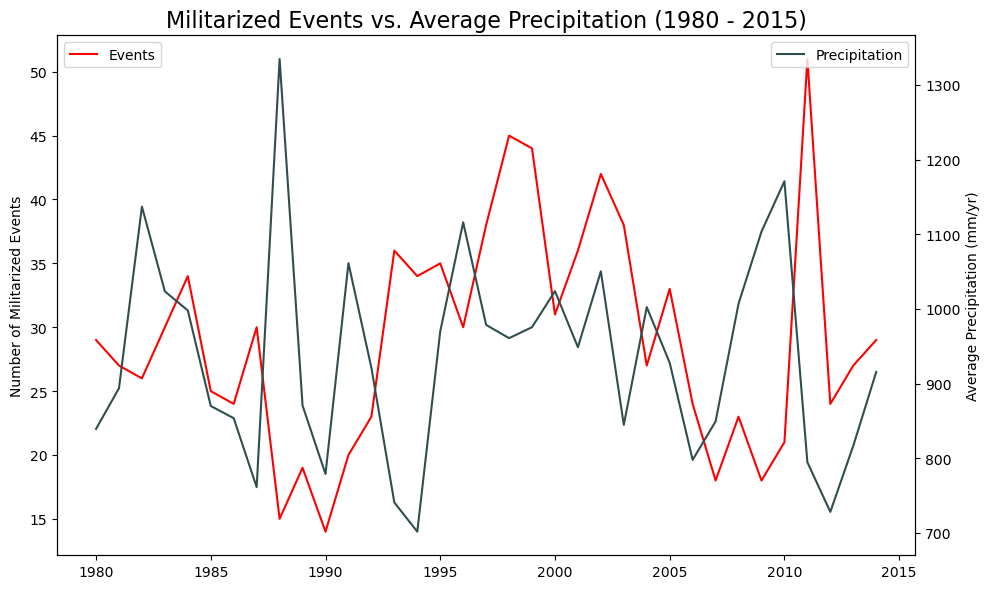

In [42]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Average Precipitation (1980 - 2015)', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Number of Militarized Events')
ax1.plot(yr_geo_df['Year'], yr_geo_df['No. Conflicts'], color='red', label='Events')
ax1.legend(loc='upper left')

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Precipitation (mm/yr)')
ax2.plot(yr_geo_df['Year'], yr_geo_df['Precipitation'], color='darkslategray', label='Precipitation')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.show()

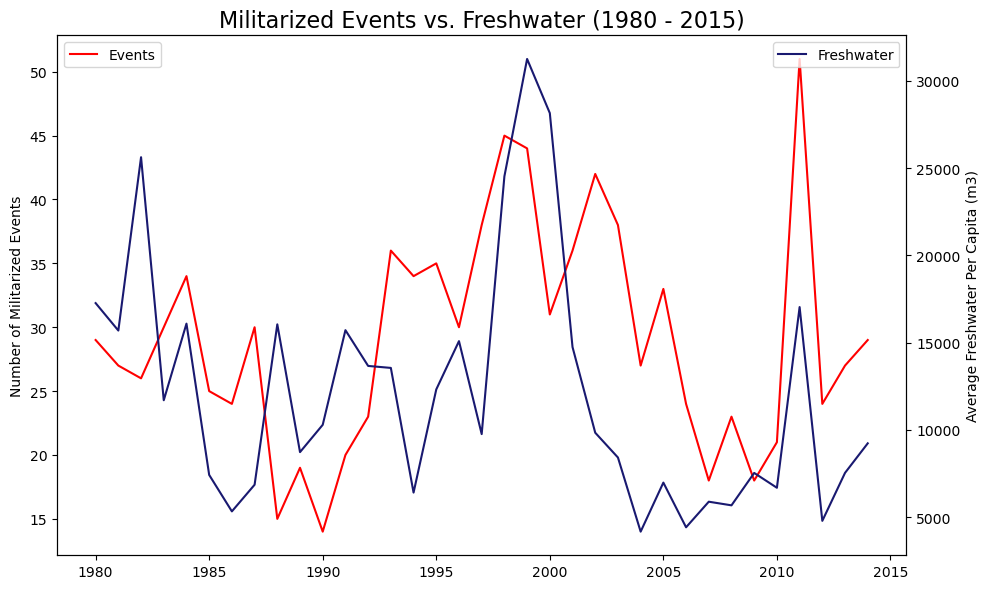

In [43]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Freshwater (1980 - 2015)', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Number of Militarized Events')
ax1.plot(yr_geo_df['Year'], yr_geo_df['No. Conflicts'], color='red', label='Events')
ax1.legend(loc='upper left')

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Freshwater Per Capita (m3)')
ax2.plot(yr_geo_df['Year'], yr_geo_df['FrshW / Cap'], color='midnightblue', label='Freshwater')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.show()

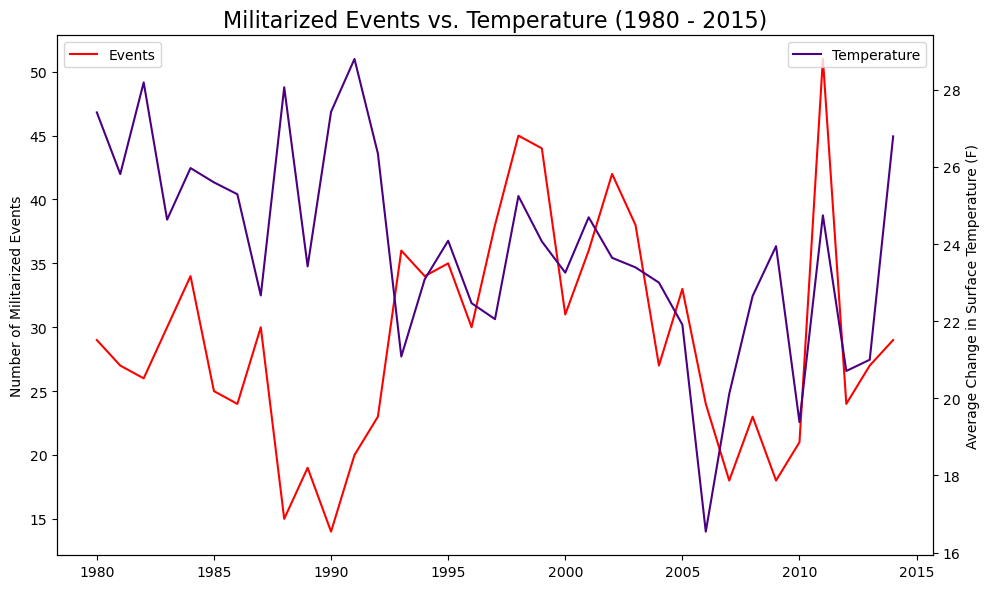

In [44]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Militarized Events vs. Temperature (1980 - 2015)', fontsize=16)

# Plot the first axis
ax1.set_ylabel('Number of Militarized Events')
ax1.plot(yr_geo_df['Year'], yr_geo_df['No. Conflicts'], color='red', label='Events')
ax1.legend(loc='upper left')

# Plot the second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Change in Surface Temperature (F)')
ax2.plot(yr_geo_df['Year'], yr_geo_df['Surf Temp'], color='indigo', label='Temperature')
ax2.legend(loc='upper right')

# Print the chart
plt.tight_layout()
plt.show()

#### Box Plot Charts

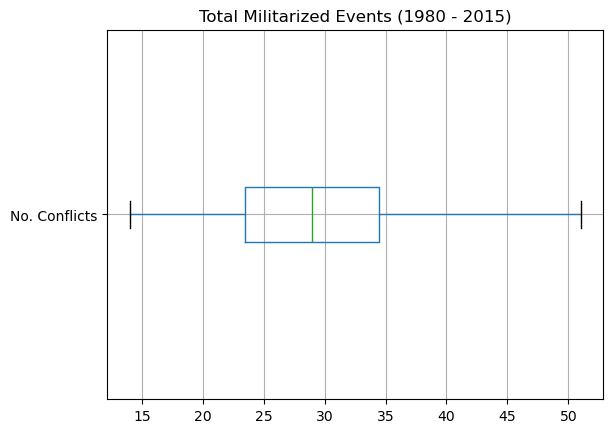

In [45]:
# Build a box plot - Conflicts
ncc_box = yr_geo_df.boxplot(column=['No. Conflicts'], vert=False, showfliers=True)

# Add a title
plt.title('Total Militarized Events (1980 - 2015)')
plt.show()

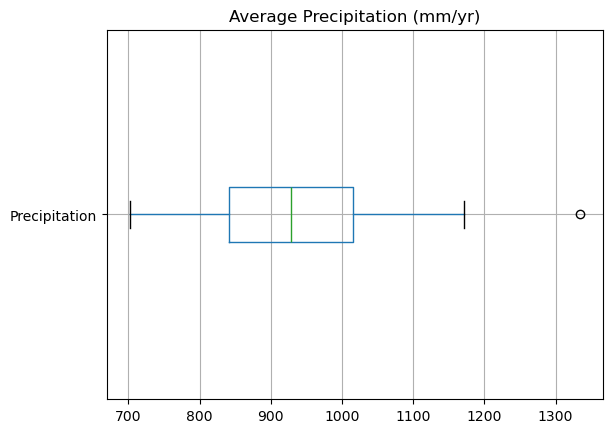

In [46]:
# Build a box plot
psc_box = yr_geo_df.boxplot(column=['Precipitation'], vert=False, showfliers=True)

# Add a title
plt.title('Average Precipitation (mm/yr)')
plt.show()

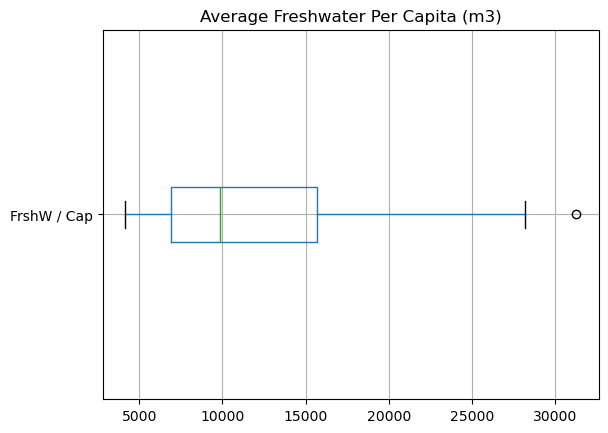

In [47]:
# Build a box plot
fwx_box = yr_geo_df.boxplot(column=['FrshW / Cap'], vert=False, showfliers=True)

# Add a title
plt.title('Average Freshwater Per Capita (m3)')
plt.show()

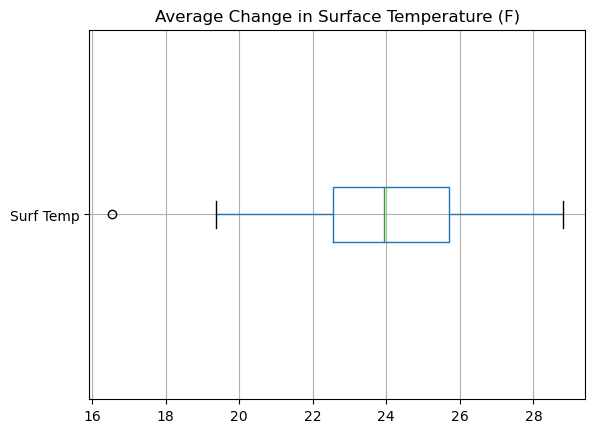

In [48]:
# Build a box plot
stc_box = yr_geo_df.boxplot(column=['Surf Temp'], vert=False, showfliers=True)

# Add a title
plt.title('Average Change in Surface Temperature (F)')
plt.show()

#### Linear Regression Charts

In [49]:
# Define the specific columns to include for analysis using in the Z-score calculation
columns_to_include = ['Precipitation', 'FrshW / Cap', 'Surf Temp', 'No. Conflicts']

# Calculate Z-scores for the selected columns
z_scores = np.abs((yr_geo_df[columns_to_include] - yr_geo_df[columns_to_include].mean()) / yr_geo_df[columns_to_include].std())

# Define a threshold for outliers (e.g., Z-score greater than 3)
threshold = 3

# Filter out the outliers based on the threshold and convert to a DataFrame
filtered_yrgeo_df = yr_geo_df[(z_scores < threshold).all(axis=1)]

# Display the dataframe
filtered_yrgeo_df.head()

# Set plot variables
t_conf = filtered_yrgeo_df['No. Conflicts']
t_pres = filtered_yrgeo_df['Precipitation']
t_fw = filtered_yrgeo_df['FrshW / Cap']
t_temp = filtered_yrgeo_df['Surf Temp']

The r-value is: 0.0333300377750328


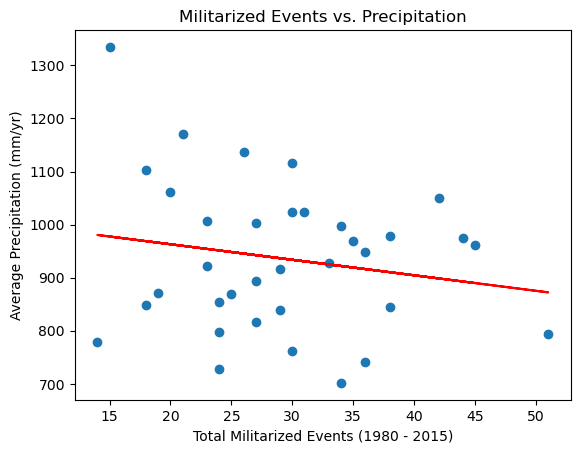

In [56]:
# Linear regression on previous plot
fig13_psc_lr = linear_regression_plot(t_conf, t_pres)

# Incorporate the other graph properties
plt.xlabel(f'Total Militarized Events (1980 - 2015)')
plt.ylabel(f'Average Precipitation (mm/yr)')
plt.title(f'Militarized Events vs. Precipitation')
plt.annotate(fig13_psc_lr, (14,3100), fontsize = 15, color = "red")

# Show plot
plt.savefig("Images/MIE_Prec_LR.png")
plt.show()

The r-value is: 0.15644219554065641


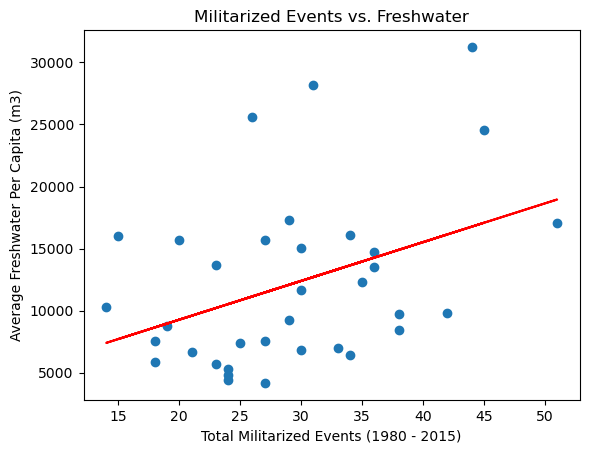

In [57]:
# Linear regression on previous plot
fig15_fwc_lr = linear_regression_plot(t_conf, t_fw)

# Incorporate the other graph properties
plt.xlabel(f'Total Militarized Events (1980 - 2015)')
plt.ylabel(f'Average Freshwater Per Capita (m3)')
plt.title(f'Militarized Events vs. Freshwater')
plt.annotate(fig15_fwc_lr, (12,200000), fontsize = 15, color = "red")

# Show plot
plt.savefig("Images/MIE_FW_LR.png")
plt.show()

The r-value is: 0.003999860022617387


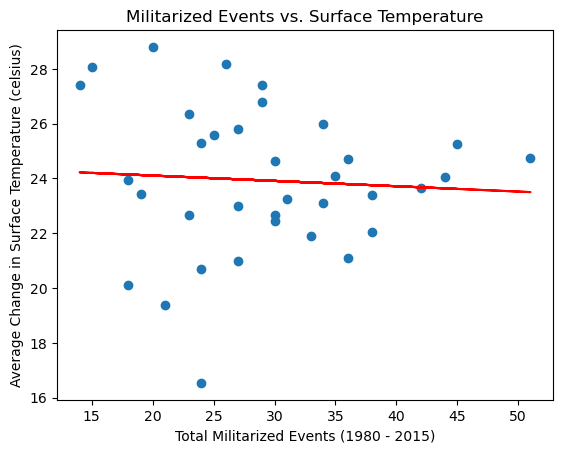

In [58]:
# Linear regression on previous plot
fig17_stc_lr = linear_regression_plot(t_conf, t_temp)

# Incorporate the other graph properties
plt.xlabel(f'Total Militarized Events (1980 - 2015)')
plt.ylabel(f'Average Change in Surface Temperature (celsius)')
plt.title(f'Militarized Events vs. Surface Temperature')
plt.annotate(fig17_stc_lr, (17,2.5), fontsize = 15, color = "red")

# Show plot
plt.savefig("Images/MIE_Temp_LR.png")
plt.show()